# Install Package (this can be placed in requirements.txt)

In [ ]:
!sudo pip install xgboost==2.0.0
# !pip install --upgrade xgboost

# Import Libraries / Packages

In [ ]:
from google.colab import drive, autoviz

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import xgboost as xgb

from matplotlib.patches import Rectangle
from seaborn import heatmap

from keras.utils import to_categorical
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix
# from sklearn.preprocessing import LabelEncoder

# Load dataset

In [ ]:
# dataset_folder = '/content/drive'
# drive.mount(dataset_folder)

# Activate this if we want to load from the google collab sample_data dir
# Or adjust to your own system filepath
df = pd.read_csv(
    # "drive/MyDrive/dataset-machine-learning/promoters.data.csv",
    # for testing i give this url (the same csv for sure)
    "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data",
    names=['class', 'id', 'sequence']
)
df.describe()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,class,id,sequence
count,106,106,106
unique,2,106,106
top,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
freq,53,1,1


# First 10 data, Total Feature & Total Class

In [ ]:
# df = pd.read_csv('sample_data/promoters.data.csv', names=['class', 'id', 'sequence'])

print(df.nunique(), "\n")

df['sequence'] = df['sequence'].apply(lambda x: x.replace('\t', ''))
print(df.head(10))

total_feature = len(df['sequence'][0])
print(f"\nTotal Feature: {total_feature}")

total_class = len(df['class'].unique())
print(f"Total Class: {total_class}")

class         2
id          106
sequence    106
dtype: int64 

  class         id                                           sequence
0     +        S10  tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1     +       AMPC  tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2     +       AROH  gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3     +      DEOP2  aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4     +  LEU1_TRNA  tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
5     +     MALEFG  aggggcaaggaggatggaaagaggttgccgtataaagaaactagag...
6     +       MALK  cagggggtggaggatttaagccatctcctgatgacgcatagtcagc...
7     +       RECA  tttctacaaaacacttgatactgtatgagcatacagtataattgct...
8     +       RPOB  cgacttaatatactgcgacaggacgtccgttctgtgtaaatcgcaa...
9     +   RRNAB_P1  ttttaaatttcctcttgtcaggccggaataactccctataatgcgc...

Total Feature: 57
Total Class: 2


# Data per Class Statistic Charts

['+' '-']
[53, 53]


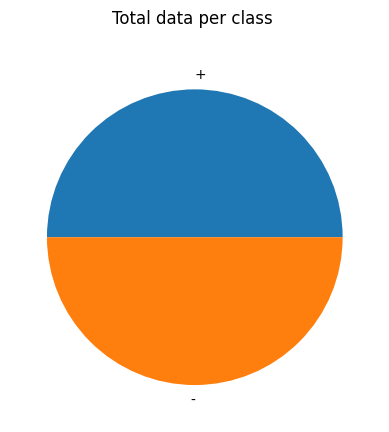

In [ ]:
classes = df['class'].unique()
print(classes)

total_per_class = [len(df[df['class'] == data_class]) for data_class in classes]
print(total_per_class)

plt.pie(total_per_class, labels=classes)
plt.title('Total data per class \n')
plt.show()

# Mean, Median, Mode, Standard Deviation, dan Kuartil dari setiap fitur data

In [ ]:
means = []
medians = []
modes = []
std_deviations = []
quartiles = []

for sequence in df['sequence']:
    # The DNA is made up of four chemical bases: Adenine(A), Guanine(G), Cytosine(C), and Thymine(T)
    # Calculate the nucleotide frequencies
    count_A = sequence.count('a')
    count_T = sequence.count('t')
    count_C = sequence.count('c')
    count_G = sequence.count('g')

    nucleotide_frequencies = [count_A, count_T, count_C, count_G]

    # Calculate the mean
    mean = sum(nucleotide_frequencies) / 4
    means.append(mean)

    # Calculate the median
    median = statistics.median(nucleotide_frequencies)
    medians.append(median)

    # Calculate the mode
    mode = statistics.mode(nucleotide_frequencies)
    modes.append(mode)

    # Calculate the standard deviation
    std_deviation = np.std(nucleotide_frequencies)
    std_deviations.append(std_deviation)

    # Calculate the quartiles
    quartile_25 = np.percentile(nucleotide_frequencies, 25)
    quartile_50 = np.percentile(nucleotide_frequencies, 50)
    quartile_75 = np.percentile(nucleotide_frequencies, 75)
    quartiles.append((quartile_25, quartile_50, quartile_75))

df['Mean'] = means # values among sample data are same
df['Median'] = medians
df['Mode'] = modes
df['Standard Deviation'] = std_deviations
df['Quartiles'] = quartiles

print (df)

    class         id                                           sequence  \
0       +        S10  tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...   
1       +       AMPC  tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...   
2       +       AROH  gtactagagaactagtgcattagcttatttttttgttatcatgcta...   
3       +      DEOP2  aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...   
4       +  LEU1_TRNA  tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...   
..    ...        ...                                                ...   
101     -        799  cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...   
102     -        987  gtattctcaacaagattaaccgacagattcaatctcgtggatggac...   
103     -       1226  cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...   
104     -        794  ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...   
105     -       1442  taacattaataaataaggaggctctaatggcactcattagccaatc...   

      Mean  Median  Mode  Standard Deviation            Quartiles  
0    14.25    14.0    11       

# Distribusi dari fitur

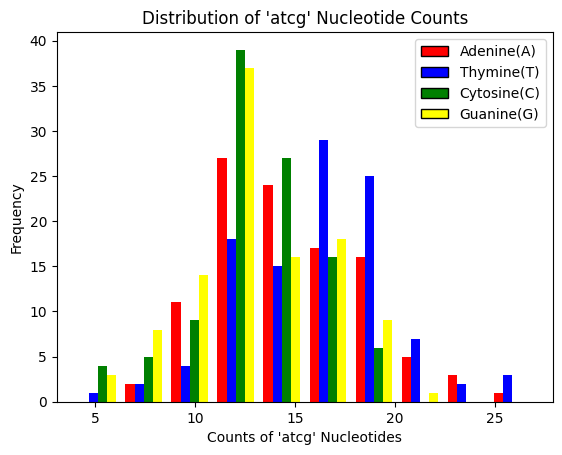

In [ ]:
a_counts = []
t_counts = []
c_counts = []
g_counts = []

for sequence in df['sequence']:
    # Calculate the 'A' nucleotide counts
    count_A = sequence.count('a')
    a_counts.append(count_A)

    count_T = sequence.count('t')
    t_counts.append(count_T)

    count_C = sequence.count('c')
    c_counts.append(count_C)

    count_G = sequence.count('g')
    g_counts.append(count_G)

def generateHistogram(data, colors, labels, xlabel, ylabel, title):
  plt.hist(data, color=colors)

  handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]

  plt.legend(handles, labels)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

total_atcg = [a_counts, t_counts, c_counts, g_counts]
colors = ['red', 'blue', 'green', 'yellow']
labels= ["Adenine(A)","Thymine(T)", "Cytosine(C)", "Guanine(G)"]
generateHistogram(
    total_atcg,
    colors,
    labels,
    "Counts of 'atcg' Nucleotides",
    "Frequency",
    "Distribution of 'atcg' Nucleotide Counts"
)

# total_atcg_2 = [[sum(a_counts)],[sum(t_counts)],[sum(c_counts)],[sum(g_counts)]]
# generateHistogram(
#     total_atcg_2,
#     colors,
#     labels,
#     "Counts of 'atcg' Nucleotides",
#     "Frequency",
#     "Distribution of 'atcg' Nucleotide Counts"
# )

# Testing display data #2
# data={'a': a_counts}
# sns.scatterplot(data, x=data['a'], y=data['a'], color=colors[0])
# plt.show()

# data={'t': t_counts}
# sns.scatterplot(data, x=data['t'], y=data['t'], color=colors[1])
# plt.show()

# data={'c': c_counts}
# sns.scatterplot(data, x=data['c'], y=data['c'], color=colors[2])
# plt.show()

# data={'g': g_counts}
# sns.scatterplot(data, x=data['g'], y=data['g'], color=colors[3])
# plt.show()

# plt.pie([sum(a_counts),sum(t_counts),sum(c_counts),sum(g_counts)], labels=labels)
# plt.show()

In [ ]:
def custom_heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = custom_heatmap(df, *['id', 'sequence'], **{})
chart

# Data Encoding

wew, i think i can use this package instead of create it manually :)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html


In [ ]:
# print(one_hot_encoding('a')) # [1. 0. 0. 0.]
# print(one_hot_encoding('c')) # [0. 1. 0. 0.]
# print(one_hot_encoding('g')) # [0. 0. 1. 0.]
# print(one_hot_encoding('t')) # [0. 0. 0. 1.]
def one_hot_encoding(seq):
  mp = dict(zip('acgt', range(4))) # {'a': 0, 'c': 1, 'g': 2, 't': 3}
  seq_2_number = [mp[nucleutide] for nucleutide in seq]

  categorical = to_categorical(seq_2_number, num_classes=4, dtype='float32')
  return categorical.flatten()

# put to the variable instead of replace df['sequences'] << due the the global scope of df
# print(df['sequence'])
sequences = df['sequence'].apply(lambda seq: one_hot_encoding(seq))
print(sequences.mean()) # check is this true?

[0.24528302 0.254717   0.14150943 0.35849056 0.3207547  0.20754717
 0.2264151  0.24528302 0.28301886 0.1981132  0.26415095 0.254717
 0.20754717 0.28301886 0.26415095 0.24528302 0.33962265 0.17924528
 0.2735849  0.20754717 0.3962264  0.16981132 0.20754717 0.2264151
 0.35849056 0.1981132  0.16037735 0.28301886 0.3207547  0.18867925
 0.18867925 0.3018868  0.31132075 0.20754717 0.17924528 0.3018868
 0.33962265 0.20754717 0.18867925 0.26415095 0.35849056 0.20754717
 0.14150943 0.29245284 0.1981132  0.29245284 0.23584905 0.2735849
 0.2735849  0.13207547 0.2735849  0.3207547  0.2264151  0.35849056
 0.21698113 0.1981132  0.21698113 0.12264151 0.1509434  0.509434
 0.16037735 0.2264151  0.10377359 0.509434   0.14150943 0.13207547
 0.5        0.2264151  0.3773585  0.2735849  0.17924528 0.16981132
 0.254717   0.41509435 0.11320755 0.21698113 0.29245284 0.2264151
 0.254717   0.2264151  0.26415095 0.20754717 0.20754717 0.3207547
 0.29245284 0.18867925 0.2735849  0.24528302 0.20754717 0.254717
 0.283

# Training and Test Configuration

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    sequences.tolist(),
    df['class'].tolist(),
    test_size=0.2, # 20%
    random_state=42
)

names = [
    "Naive Bayes",
    "Decision Tree",
    "KNN",
    "Support Vector Machine",

    "Logistic Regression",
    "GradientBoosting",
    "AdaBoost",
    "Random Forest",

    # "Gaussian Process",
    # "Neural Net",
  ]

classifiers = [
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression(
      # without set max_iter will get error:
      # https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
        max_iter=95
    ),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier(),

    # Testing other models
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    # MLPClassifier(alpha=1, max_iter=500), # remove max_iter to let it tries to the max
]

# print(classifiers)

# print(X_train)
# print(X_test)
# print(y_train)
# print(y_test)

# Training & Testing

In [ ]:
for name, classifier in zip(names, classifiers):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print(name, ': ' , accuracy_score(y_test, predictions))
    # print(classification_report(y_test, predictions))

# always changing values: random forest, decision tree,

Naive Bayes :  0.9545454545454546
Decision Tree :  0.6818181818181818
KNN :  0.7272727272727273
Support Vector Machine :  0.9090909090909091
Logistic Regression :  0.8636363636363636
GradientBoosting :  0.7727272727272727
AdaBoost :  1.0
Random Forest :  0.8181818181818182


# Cross Validation

In [ ]:
validation_type = model_selection.KFold(n_splits = 10)
cv_result = []
for classifier in classifiers:
  cv_result.append(
      model_selection.cross_val_score(
          classifier,
          X_train,
          y_train,
          cv = validation_type,
          scoring = 'accuracy'
      ).mean()
  )

for i in range(len(names)):
  print(f"The cross validation score of {names[i]} is {cv_result[i]}")

# always changing values: random forest, decision tree

The cross validation score of Naive Bayes is 0.8861111111111111
The cross validation score of Decision Tree is 0.8180555555555555
The cross validation score of KNN is 0.7916666666666666
The cross validation score of Support Vector Machine is 0.913888888888889
The cross validation score of Logistic Regression is 0.9388888888888889
The cross validation score of GradientBoosting is 0.9027777777777779
The cross validation score of AdaBoost is 0.8930555555555555
The cross validation score of Random Forest is 0.8930555555555555


# XGBoost algorithm

In [ ]:
# Convert the list to a NumPy array
xtr = np.array(X_train)
ytr = np.array(y_train)
xte = np.array(X_test)
yte = np.array(y_test)

# Replace + and - to number (xgb cannot receive letters)
label_mapping = {'+': 1, '-': 0}
y_train_encoded = [label_mapping[label] for label in ytr]
y_train_xgboost = np.array(y_train_encoded)

y_test_encoded = [label_mapping[label] for label in yte]
y_test_xgboost = np.array(y_test_encoded)

# print(y_train_xgboost)
# print(y_test_xgboost)

dtrain = xgb.DMatrix(xtr, label=y_train_xgboost)
dtest = xgb.DMatrix(xte, label=y_test_xgboost)

param = {
    'num_class': 2,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'max_depth': 1,  # the maximum depth of each tree
    'eta': 0.3  # training step
}  # the number of classes that exist in this datset
num_round = 25  # the number of training iterations, affected the result

#train model
start = time.time()
bst = xgb.train(param, dtrain, num_round)
end = time.time()
print("training time:", end - start)

bst.dump_model('dump.raw.txt') #overview of model

# predict
start = time.time()
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
end = time.time()
print("testing time:", end - start)

# precision_score = precision_score(y_test_xgboost, best_preds, average='macro')
# print(f"precision_score: {precision_score}")

accuration_score = accuracy_score(y_test_xgboost, best_preds)
print(f"accuration_score: {accuration_score}")

# confusion_matrix = confusion_matrix(y_test_xgboost, best_preds)
# print(f"confusion_matrix: \n {confusion_matrix}")

# ax = heatmap(confusion_matrix, annot=True, fmt='.4g')
# ax.set(ylabel="Actual", xlabel="Predicted", title="Confusion Matrix")

training time: 0.11319398880004883
testing time: 0.0007801055908203125
accuration_score: 0.9545454545454546


# XGBoost 10 cross validation

In [ ]:
accuracies = []

# Initialize KFold cross-validator
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

for train_index, test_index in kf.split(xtr):
    X_train_fold, X_test_fold = xtr[train_index], xtr[test_index]
    y_train_fold, y_test_fold = y_train_xgboost[train_index], y_train_xgboost[test_index]

    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)

    # Train the XGBoost model on the training fold
    bst = xgb.train(param, dtrain_fold, num_boost_round=num_round)

    # Create DMatrix for the test fold
    dtest_fold = xgb.DMatrix(X_test_fold)

    # Predict on the test fold
    preds = bst.predict(dtest_fold)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    # Calculate accuracy on the test fold
    accuracy = accuracy_score(y_test_fold, best_preds)
    accuracies.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print("Mean accuracy:", mean_accuracy)

Mean accuracy: 0.8958333333333333


# Hyper Parameter

In [ ]:
hp_names = [
    "Naive Bayes",
    "Decision Tree",
    "KNN",
    "Support Vector Machine",
    "Logistic Regression",
    "Gradient Boosting",
    "AdaBoost",
    "Random Forest",
  ]

hp_classifiers = [
    GaussianNB(
      # priors=[0.5, 0.5],
      #var_smoothing=0.3511191734215131
      var_smoothing=1e-9
    ),
    DecisionTreeClassifier(
      splitter="best", # random, best (default)
      criterion="gini", # entropy, log_loss, gini (default)
      max_depth=1, # Default None
      min_samples_split=2, # default 2
      min_samples_leaf=25,
      max_features=None # int, float or {“auto”, “sqrt”, “log2”}, None (default)
    ),
    KNeighborsClassifier(
      n_neighbors=3, # default: 5
      weights='distance', # uniform (default), distance
      algorithm='auto', # ‘ball_tree’, ‘kd_tree’, ‘brute’, ‘auto’ (default)
      p=2, # default: 2
      n_jobs=None # default: None
    ),
    SVC(
      C=0.1, # default=1.0
      kernel='rbf', #"linear", "poly", "rbf" (default), "sigmoid", "precomputed"
      gamma="scale", # scale (default), auto or FLOAT
      coef0=0.0, # default=0.0
      tol=1e-3 # default=1e-3
    ),
    GradientBoostingClassifier(
      n_estimators=100,
      learning_rate=0.1,
      max_depth=3,
      random_state=0
    ),
    LogisticRegression(
      max_iter=32,
      C=0.3,
      tol=0.7, # 1e-4(default)
      penalty='l2', # {‘l1’, ‘l2’ (default), ‘elasticnet’, None}
      solver='lbfgs'# 'lbfgs' (default), 'liblinear', 'sag', 'saga'
    ),
    AdaBoostClassifier(
      n_estimators=100,
      learning_rate=0.4,
      algorithm='SAMME'
    ),
    RandomForestClassifier(
      max_depth=5,
      n_estimators=100,
      max_features='sqrt', #  sqrt (default), log2, None
      min_samples_split=2,
      min_samples_leaf=1
    )
]

for hp_name, hp_classifier in zip(hp_names, hp_classifiers):
    hp_classifier.fit(X_train, y_train)
    hp_predictions = hp_classifier.predict(X_test)
    print(hp_name, ': ' , accuracy_score(y_test, hp_predictions))


Naive Bayes :  0.9545454545454546
Decision Tree :  0.7272727272727273
KNN :  0.8181818181818182
Support Vector Machine :  0.8636363636363636
Logistic Regression :  0.7727272727272727
Gradient Boosting :  0.9090909090909091
AdaBoost :  0.9090909090909091
Random Forest :  0.9090909090909091


# Hyper Parameter using Grid Search

Grid Search Cross Validation adalah metode pemilihan kombinasi model dan hyperparameter dengan cara menguji coba satu persatu kombinasi dan melakukan validasi untuk setiap kombinasi. Tujuannya adalah menentukan kombinasi yang menghasilkan performa model terbaik yang dapat dipilih untuk dijadikan model untuk prediksi.

In [ ]:
  models = [
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier()
  ]

params = [
    {
      # Naive Bayes
      'var_smoothing': np.logspace(0,-9, num=100),
      'priors': [
          [0.2, 0.8],
          [0.5, 0.5]
      ]
    },
    {
        # DT
        'splitter': ['best'],
        'criterion': ['gini'],
        'max_depth': [1],
        'min_samples_split': [2],
        'min_samples_leaf': [25],
    },
    {
       # KNN
      'n_neighbors': [1,2,3,4,5],
      'weights': ['distance'],
      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
      'p': [1,2,3,4,5],
      'n_jobs': [1,2,3,4, 5]
    },
    {
      # SVM
      # Higher values of C incentivize the model to fit the training data more tightly,
      # but lead to overfitting if you make it too high (the noisier the data, the worse it gets).
      'C': [0.1, 0.5, 1, 2, 5, 10],
      'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
      'tol': [1e-3, 1e-4, 1e-5, 1e-6]
    },
    {
        # Logistic Regression
      'C': [1e-10, 1e-1, 0.1, 0.3, 0.10, 1, 10],
      'tol': [1e-10, 1e-4, 0.7, 0.1, 1, 10],
      'solver': ['lbfgs']
    },
    {
        # Gradient Boosting
    },
    {
        # AdaBoost
    },
    {
        # Random Forest
        # the total number of trees in the forest, along with feature space sampling percentages
    }
]

# for model, param in zip([models[4]], [params[4]]): # Testing only 1 model
for model, param in zip(models, params):
  gs_cv = GridSearchCV(
      model,
      param,
      # cv=10
    )

  gs_cv.fit(X_train, y_train)
  print(f"Model: {model} ")
  print(gs_cv.best_params_)
  print(gs_cv.best_score_)
  print("\n")

  # print(sorted(gs_cv.cv_results_.keys()))
  # print(gs_cv.cv_results_)

Model: GaussianNB() 
{'priors': [0.2, 0.8], 'var_smoothing': 0.3511191734215131}
0.9154411764705882


Model: DecisionTreeClassifier() 
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 25, 'min_samples_split': 2, 'splitter': 'best'}
0.724264705882353


Model: KNeighborsClassifier() 
{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.8683823529411765


Model: SVC() 
{'C': 0.5, 'kernel': 'poly', 'tol': 0.001}
0.9272058823529411


Model: LogisticRegression() 
{'C': 0.1, 'solver': 'lbfgs', 'tol': 0.7}
0.9272058823529411


Model: GradientBoostingClassifier() 
{}
0.9051470588235293


Model: AdaBoostClassifier() 
{}
0.8801470588235294


Model: RandomForestClassifier() 
{}
0.9029411764705882


